In [19]:
import pandas as pd
from sklearn.metrics import classification_report, accuracy_score
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Load data
ground_truth = pd.read_csv("../source_data/test_preprocess.csv")
predictions = {
    "SVM": pd.read_csv('../evaluation/svm_predictions.csv'),
    "IndoBERT": pd.read_csv('../evaluation/bert_predictions.csv'),
    # zero-shot models
    "GPT-3.5 Turbo Zero-Shot": pd.read_csv('../evaluation/zero_shot_gpt-3.5-turbo_predictions.csv'),
    "GPT-4 Turbo Zero-Shot": pd.read_csv('../evaluation/zero_shot_gpt-4-turbo_predictions.csv'),
    "GPT-4o Zero-Shot": pd.read_csv('../evaluation/zero_shot_gpt-4o_predictions.csv'),
    # few-shot models
    "GPT-3.5 Turbo Few-Shot": pd.read_csv('../evaluation/few_shot_gpt-3.5-turbo_predictions.csv'),
    "GPT-4 Turbo Few-Shot": pd.read_csv('../evaluation/few_shot_gpt-4-turbo_predictions.csv'),
    "GPT-4o Few-Shot": pd.read_csv('../evaluation/few_shot_gpt-4o_predictions.csv'),
}

# Configuration
aspect_keys = ["ac", "air_panas", "bau", "general", "kebersihan", 
               "linen", "service", "sunrise_meal", "tv", "wifi"]

In [21]:
def evaluate_model(true_df, pred_df, model_name):
    """Core evaluation function for a single model"""
    merged = true_df.merge(pred_df, on="review", suffixes=('_true', '_pred'))
    results = []
    
    for aspect in aspect_keys:
        y_true = merged[f"{aspect}_true"]
        y_pred = merged[f"{aspect}_pred"]
        
        report = classification_report(y_true, y_pred, 
                                      target_names=['neg', 'pos', 'neut'],
                                      output_dict=True)
        
        results.append({
            'model': model_name,
            'aspect': aspect,
            'accuracy': accuracy_score(y_true, y_pred),
            'macro_precision': report['macro avg']['precision'],
            'macro_recall': report['macro avg']['recall'],
            'macro_f1': report['macro avg']['f1-score'],
            'weighted_precision': report['weighted avg']['precision'],
            'weighted_recall': report['weighted avg']['recall'],
            'weighted_f1': report['weighted avg']['f1-score'],
            'neg_precision': report['neg']['precision'],
            'neg_recall': report['neg']['recall'],
            'neg_f1': report['neg']['f1-score'],
            'pos_precision': report['pos']['precision'],
            'pos_recall': report['pos']['recall'],
            'pos_f1': report['pos']['f1-score'],
            'neut_precision': report['neut']['precision'],
            'neut_recall': report['neut']['recall'],
            'neut_f1': report['neut']['f1-score'],
            'support': report['weighted avg']['support']
        })
    
    return pd.DataFrame(results)

In [22]:
# Main evaluation pipeline
all_results = []
for model_name, pred_df in predictions.items():
    print(f"Evaluating {model_name}...")
    model_results = evaluate_model(ground_truth, pred_df, model_name)
    all_results.append(model_results)

# Generate key outputs
full_results = pd.concat(all_results, ignore_index=True)

Evaluating SVM...
Evaluating IndoBERT...
Evaluating GPT-3.5 Turbo Zero-Shot...
Evaluating GPT-4 Turbo Zero-Shot...
Evaluating GPT-4o Zero-Shot...
Evaluating GPT-3.5 Turbo Few-Shot...
Evaluating GPT-4 Turbo Few-Shot...
Evaluating GPT-4o Few-Shot...


# Overall Accuracy

In [23]:
# 1. Model Comparison Table
model_comparison = full_results.groupby('model').agg({
    'accuracy': 'mean',
    'macro_precision': 'mean',
    'macro_recall': 'mean',
    'macro_f1': 'mean',
    'weighted_precision': 'mean',
    'weighted_recall': 'mean',
    'weighted_f1': 'mean',
    'neg_precision': 'mean',
    'neg_recall': 'mean',
    'neg_f1': 'mean',
    'pos_precision': 'mean',
    'pos_recall': 'mean',
    'pos_f1': 'mean',
    'neut_precision': 'mean',
    'neut_recall': 'mean',
    'neut_f1': 'mean',
    'support': 'mean'
}).reset_index()

print("\n=== AVG Model Comparison ===")
model_comparison[["model", "accuracy"]].round(4)


=== AVG Model Comparison ===


,model,accuracy
0,GPT-3.5 Turbo Few-Shot,0.9143
1,GPT-3.5 Turbo Zero-Shot,0.9042
2,GPT-4 Turbo Few-Shot,0.9500
3,GPT-4 Turbo Zero-Shot,0.9427
4,GPT-4o Few-Shot,0.9612
5,GPT-4o Zero-Shot,0.9175
6,IndoBERT,0.9608
7,SVM,0.9350


Sampled since fewshot more relevant approach for llm

In [24]:
model_order = [
    "GPT-3.5 Turbo Few-Shot",
    "GPT-4 Turbo Few-Shot",
    "GPT-4o Few-Shot",
    "IndoBERT",
    "SVM"
]

# Macro & Weighted Performance

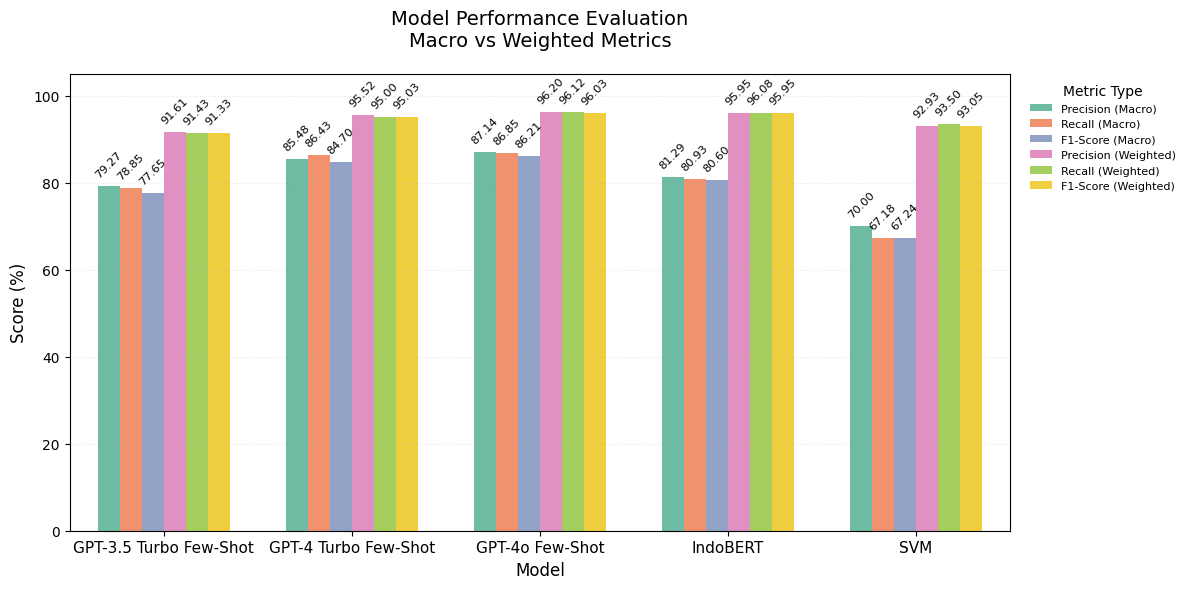

In [ ]:
# Filter and prepare data
metrics = ["precision", "recall", "f1"]
combined_df = pd.concat([
    model_comparison[model_comparison["model"].isin(model_order)].melt(
        id_vars=["model"],
        value_vars=[f"macro_{m}" for m in metrics],
        var_name="Metric",
        value_name="Score"
    ).assign(Type="Macro"),
    model_comparison[model_comparison["model"].isin(model_order)].melt(
        id_vars=["model"],
        value_vars=[f"weighted_{m}" for m in metrics],
        var_name="Metric",
        value_name="Score"
    ).assign(Type="Weighted")
])

# Convert model column to categorical with specified order
combined_df["model"] = pd.Categorical(
    combined_df["model"],
    categories=model_order,
    ordered=True
)

# Clean labels and create hue
combined_df["Metric"] = combined_df["Metric"].str.replace("(macro_|weighted_)", "", regex=True).str.title()
combined_df["Metric"] = combined_df["Metric"].replace("F1", "F1-Score")
combined_df["Metric_Type"] = combined_df["Metric"] + " (" + combined_df["Type"] + ")"
combined_df["Score"] = combined_df["Score"] * 100  # Convert to percentage

# Create plot with optimized proportions
plt.figure(figsize=(12, 6))
ax = sns.barplot(
    data=combined_df,
    x="model",
    y="Score",
    hue="Metric_Type",
    palette="Set2",
    dodge=True,
    saturation=0.85,
    width=0.7,
    order=model_order  # Ensure the order is maintained
)

# Customize plot
plt.title("Model Performance Evaluation\nMacro vs Weighted Metrics", fontsize=14, pad=20)
plt.xlabel("Model", fontsize=12)
plt.ylabel("Score (%)", fontsize=12)
plt.xticks(rotation=0, ha="center", fontsize=11)  # Horizontal labels
plt.ylim(0, 105)

# Optimized label placement
for p in ax.patches:
    height = p.get_height()
    if height > 1:
        ax.text(
            p.get_x() + p.get_width()/2,
            height + 1.5,  # Tight offset
            f'{height:.2f}',  # Clean percentage format
            ha='center',
            va='bottom',
            fontsize=8.25,
            color='black',
            rotation=45
        )

# Improved legend
ax.legend(
    title="Metric Type",
    bbox_to_anchor=(1.01, 1),
    loc="upper left",
    frameon=False,
    fontsize=8
)

# Add subtle grid
ax.yaxis.grid(True, linestyle=":", alpha=0.3)

plt.tight_layout()
plt.show()

# Aspect Level

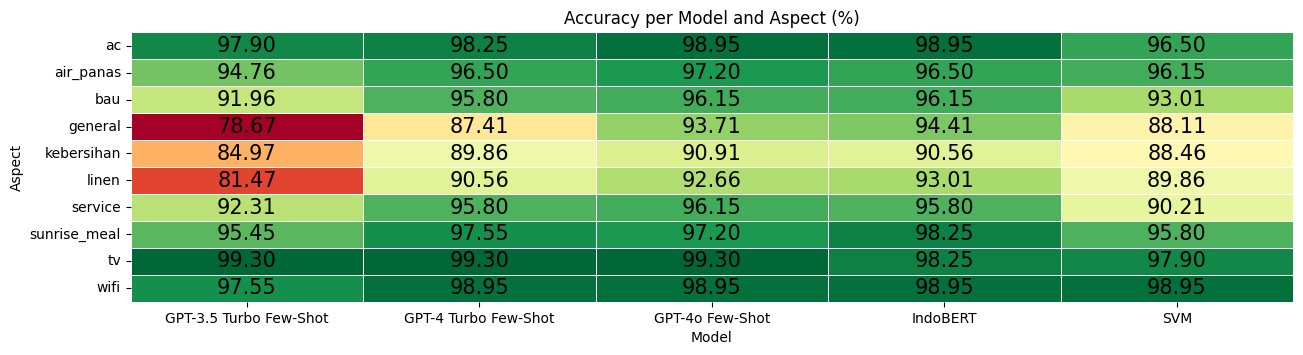

In [26]:
df_sampled = full_results[full_results["model"].isin(model_order)]
plt.figure(figsize=(15, 3.5))
heatmap_data = df_sampled.pivot_table(index="aspect", columns="model", values="accuracy", aggfunc="mean")

sns.heatmap(
    heatmap_data * 100,
    annot=True,
    cmap="RdYlGn",
    fmt=".2f",
    linewidths=0.5,
    cbar=False,
    annot_kws={"color": "black", "size": 15}
)

plt.title("Accuracy per Model and Aspect (%)")
plt.xlabel("Model")
plt.ylabel("Aspect")
plt.show()